Basic Statistics:
              Width        Height          Size
count  11106.000000  11106.000000  1.110600e+04
mean     743.113632    735.070322  1.006300e+05
std      513.579267    533.361875  1.802737e+05
min      256.000000    256.000000  5.892000e+03
25%      480.000000    415.000000  3.435125e+04
50%      600.000000    600.000000  5.483050e+04
75%      800.000000    849.000000  9.977550e+04
max     8000.000000   7780.000000  3.802873e+06


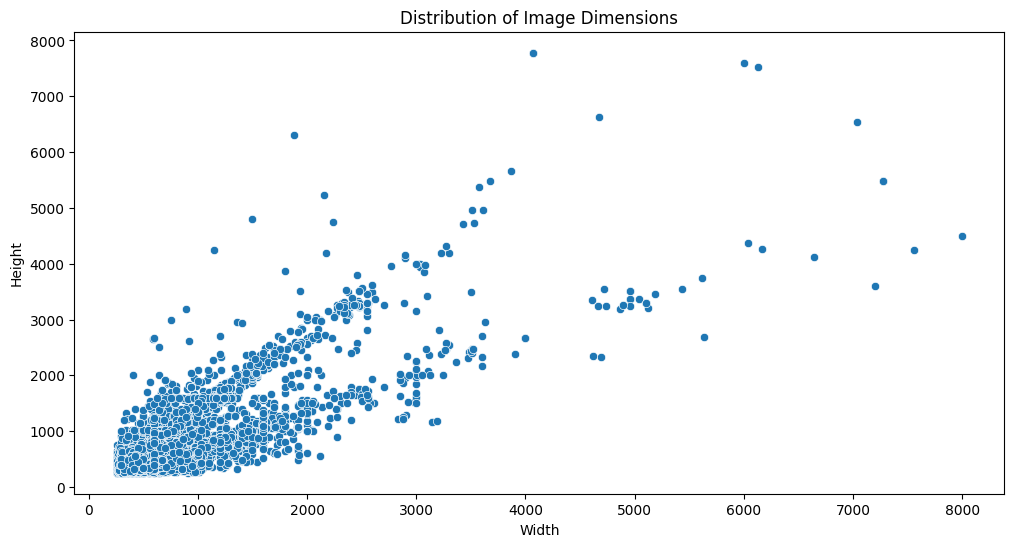

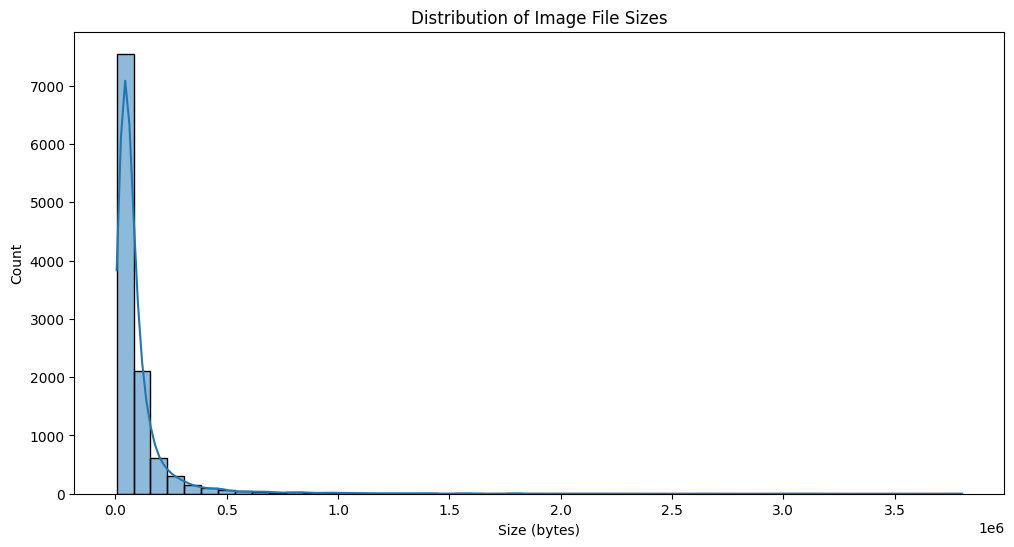

In [2]:
import os
import zipfile
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to the zip files
zip_file_path_0 = 'subfolder-0.zip'
zip_file_path_1 = 'subfolder-1.zip'

# Directory where you want to extract the datasets
extract_to_dir = 'Bilder'

def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Extract the datasets
extract_zip(zip_file_path_0, extract_to_dir)
extract_zip(zip_file_path_1, extract_to_dir)

def analyze_images(directory):
    image_data = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    width, height = img.size
                    image_data.append([file, width, height, img.mode, os.path.getsize(image_path)])
    
    return pd.DataFrame(image_data, columns=['Filename', 'Width', 'Height', 'Mode', 'Size'])

# Analyze the extracted images
combined_df = analyze_images(extract_to_dir)

# Basic statistics
print("Basic Statistics:")
print(combined_df.describe())

# Distribution of image dimensions
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Width', y='Height', data=combined_df)
plt.title('Distribution of Image Dimensions')
plt.show()

# Distribution of image file sizes
plt.figure(figsize=(12, 6))
sns.histplot(combined_df['Size'], bins=50, kde=True)
plt.title('Distribution of Image File Sizes')
plt.xlabel('Size (bytes)')
plt.ylabel('Count')
plt.show()

In [3]:
from PIL import Image
import numpy as np
import os

def calculate_average_color(image_path):
    with Image.open(image_path) as img:
        # Convert image to numpy array
        np_img = np.array(img)
        # Calculate mean of each channel (R, G, B)
        mean_colors = np.mean(np_img, axis=(0, 1))
        return mean_colors

# Add a column for average color
combined_df['Average_Color'] = combined_df['Filename'].apply(lambda x: calculate_average_color(os.path.join(extract_to_dir, x)))

print(combined_df.head())


FileNotFoundError: [Errno 2] No such file or directory: 'Bilder\\10000.jpg'

In [2]:
from transformers import CLIPProcessor, CLIPModel
from IPython.display import Image, display
from PIL import Image

from embed_images import *
# Initialize the CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

def find_relevant_images(text_query):
    # Convert text query to embedding
    inputs = processor(text=text_query, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    text_embedding = text_features.cpu().numpy()[0]

    # Search in Qdrant
    search_results = client.search(
        collection_name=collection_name,
        query_vector=text_embedding.tolist(),
        limit=10  # Use 'limit' instead of 'top'
    )

    # Retrieve images based on search results
    image_paths = [result.payload['path'] for result in search_results]

    return image_paths

def display_images(image_paths):
    for image_path in image_paths:
        display(Image(filename=image_path))

# Example usage
text_query = "black cat"
relevant_images = find_relevant_images(text_query)
print(relevant_images)

relevant_images_paths = find_relevant_images(text_query)
display_images(relevant_images_paths)

KeyboardInterrupt: 